# Cis-eQTL Peak Overlap

**Created**: 14 December 2021

## Environment

In [1]:
library(tidyverse)
library(data.table)
library(parallel)
library(GenomicRanges)

setwd("~/eQTL_pQTL_Characterization")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:pa

## Load Data

In [2]:
cis.eqtl <- readRDS("/nfs/users/nfs_n/nm18/gains_team282/eqtl/cisresults/cisqtl_all_significant.rds")

In [3]:
head(cis.eqtl)

snps,gene,statistic,pvalue,beta,se,chr,SNPpos,TSS,threshold
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>
rs4987343,ENSG00000000457,-4.152142,3.720893e-05,-0.04958163,0.01194122,1,169699715,169894267,3.873864e-05
rs4987340,ENSG00000000457,-4.240369,2.546937e-05,-0.05063396,0.01194093,1,169700002,169894267,3.873864e-05
rs2298899,ENSG00000000457,4.176920,3.365090e-05,0.05505924,0.01318178,1,169700591,169894267,3.873864e-05
rs4987328,ENSG00000000457,4.252010,2.432691e-05,0.05597519,0.01316441,1,169701315,169894267,3.873864e-05
rs4987327,ENSG00000000457,-4.218194,2.799604e-05,-0.05023696,0.01190959,1,169701799,169894267,3.873864e-05
rs4987326,ENSG00000000457,-4.218194,2.799604e-05,-0.05023696,0.01190959,1,169701800,169894267,3.873864e-05


In [4]:
geno <- fread("~/gains_team282/Genotyping/All_genotyping_merged_filtered_b38_refiltered_rsID.bim")
colnames(geno) <- c("chr", "snp", "cM", "pos", "minor", "major")

In [5]:
head(geno)

chr,snp,cM,pos,minor,major
<chr>,<chr>,<int>,<int>,<chr>,<chr>
1,rs3131972,0,817341,A,G
1,rs546843995,0,818053,0,G
1,rs553916047,0,818359,0,A
1,1:818740_T_C,0,818740,T,C
1,rs145604921,0,819378,0,C
1,rs535256652,0,821053,0,T


In [6]:
cis.eqtl.conditional <- readRDS("/nfs/users/nfs_n/nm18/gains_team282/eqtl/cisresults/conditionalanalysis/conditional_eQTL_results_final.rds")
cis.eqtl.conditional <- merge(cis.eqtl.conditional, geno, by.x="SNP", by.y="snp") %>%
    dplyr::select(snps=SNP, gene=Gene, pvalue, beta=eQTL_beta, se=eQTL_SE, chr, SNPpos=pos) %>%
    dplyr::mutate(pvalue=as.numeric(pvalue)) %>%
    dplyr::mutate(beta=as.numeric(beta)) %>%
    dplyr::mutate(se=as.numeric(se)) %>%
    dplyr::mutate(chr=as.numeric(chr))

In [7]:
head(cis.eqtl.conditional)

,snps,gene,pvalue,beta,se,chr,SNPpos
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,rs10000507,ENSG00000164305,1.194703e-05,-0.05880549,0.013312181,4,184698127
2,rs10000850,ENSG00000128039,7.576675e-43,-0.64265343,0.043284640,4,55634211
3,rs1000137,ENSG00000272839,1.261994e-13,-0.17162745,0.022657505,7,157851460
4,rs10001795,ENSG00000121892,2.088410e-05,-0.03630321,0.008460434,4,40366982
5,rs10004630,ENSG00000170390,1.804495e-17,0.12054523,0.013573487,4,150065588
6,rs10007349,ENSG00000038210,1.368337e-07,0.11265677,0.021188828,4,25224916


In [8]:
da.peaks.ia <- read.csv("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/da_peak_ia_set.csv", row.names=1)

In [9]:
head(da.peaks.ia)

,Contrast,Cell.Type,Peak.ID,Peak.Chr,Peak.Start,Peak.End,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,9:99471421-99473127,9,99471421,99473127,4.595518,0.7066744,11.638235,1.796624e-23,9.354896e-18,40.81007
2,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,10:90977111-90978775,10,90977111,90978775,3.274519,1.2295123,11.180137,3.607667e-22,9.392434e-17,38.71995
3,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,21:14559004-14559721,21,14559004,14559721,4.160939,0.4478270,10.342869,8.255022e-20,1.432777e-14,33.07684
4,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,10:5830337-5831542,10,5830337,5831542,3.072278,1.2447989,10.213600,1.895638e-19,2.467614e-14,32.83041
5,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,13:50244295-50245833,13,50244295,50245833,3.775304,3.1500103,9.782001,2.987349e-18,3.110983e-13,30.50595
6,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,16:19293854-19294928,16,19293854,19294928,5.096038,1.0018183,9.643369,7.195948e-18,6.244800e-13,28.86840


In [10]:
da.peaks.rm <- read.csv("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/da_peak_rm_set.csv", row.names=1)

In [11]:
head(da.peaks.rm)

,Contrast,Treatment,Peak.ID,Peak.Chr,Peak.Start,Peak.End,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,BGP-Baseline,BGP,KI270544.1:31-1184,KI270544.1,31,1184,-1.447298,3.947764,-9.070917,7.083231e-17,7.838988e-12,27.668634
2,BGP-Baseline,BGP,12:37245731-37247489,12,37245731,37247489,-1.078930,3.817478,-7.113044,1.610547e-11,5.320069e-07,15.794319
3,BGP-Baseline,BGP,9:131697297-131699134,9,131697297,131699134,1.213276,3.099338,6.220933,2.495496e-09,5.640150e-05,10.932631
4,BGP-Baseline,BGP,2:121609869-121612518,2,121609869,121612518,-1.221984,3.134198,-6.165224,3.370620e-09,7.035032e-05,10.641068
5,BGP-Baseline,BGP,17:81148442-81151179,17,81148442,81151179,1.092273,3.579900,6.001654,8.063875e-09,1.505578e-04,9.847272
6,BGP-Baseline,BGP,12:35748889-35750185,12,35748889,35750185,-1.467389,1.874208,-5.688442,4.099651e-08,7.041970e-04,8.144965


In [64]:
de.genes <- read.csv("~/gains_team282/epigenetics/calderon_et_al/analysis/rna_seq/de_genes_set.csv", row.names=1)

In [65]:
head(de.genes)

,Contrast,Cell.Type,Gene.ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,ENSG00000102970,13.206387,-2.4518447,10.211362,2.641480e-18,1.200790e-13,29.29440
2,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,ENSG00000102962,14.045698,0.1852604,9.370447,3.113958e-16,7.077871e-12,24.98647
3,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,ENSG00000120129,-9.582693,6.5374414,-9.219561,7.280905e-16,1.103276e-11,23.96340
4,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,ENSG00000067082,-4.513358,9.3062946,-9.104843,1.386441e-15,1.575655e-11,24.57565
5,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,ENSG00000167414,10.289212,-1.0869950,8.559219,2.897685e-14,2.634517e-10,20.98981
6,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,ENSG00000157514,-8.252973,6.0139470,-8.506161,3.885080e-14,2.943531e-10,20.60167


In [14]:
susie.snps <- lapply(1:23, function(chr) {
    fread(paste0("~/gains_team282/nikhil/colocalization/cis_eqtl/fine_mapping/chr", chr, "_credible_sets.tsv"))
}) %>% do.call(rbind, .) %>%
    as.data.frame() %>%
    merge(., geno, by.x="SNP", by.y="snp") %>%
    dplyr::filter(is.na(Notes))

In [15]:
head(susie.snps)

,SNP,Gene,SNP_Prob,Credible_Set,Notes,chr,cM,pos,minor,major
,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
1,rs10000015,ENSG00000250057,0.053858494,2,NA,4,0,83222834,G,A
2,rs10000213,ENSG00000173085,0.008833020,2,NA,4,0,83223036,G,A
3,rs10000213,ENSG00000248401,0.027143350,1,NA,4,0,83223036,G,A
4,rs10000254,ENSG00000250131,0.005345686,4,NA,4,0,177495952,A,G
5,rs10000271,ENSG00000173085,0.008833020,2,NA,4,0,83223051,G,A
6,rs10000271,ENSG00000248401,0.027143350,1,NA,4,0,83223051,G,A


In [16]:
modules <- read.csv("~/gains_team282/nikhil/expression/gene_expression/modules.csv")

In [17]:
head(modules)

,Gene,Module
,<chr>,<chr>
1,ENSG00000005206,Module_1
2,ENSG00000005243,Module_1
3,ENSG00000005448,Module_1
4,ENSG00000005882,Module_1
5,ENSG00000006831,Module_1
6,ENSG00000007168,Module_1


In [18]:
modules.k <- read.csv("~/gains_team282/nikhil/expression/gene_expression/connectivity.csv", row.names=1) %>%
    dplyr::mutate(Gene=rownames(.)) %>%
    dplyr::select(Gene, everything())

In [19]:
head(modules.k)

,Gene,kTotal,kWithin,kOut,kDiff,Module
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000005206,ENSG00000005206,1.049468,0.1772570,0.872211,-0.6949541,Module_1
ENSG00000005243,ENSG00000005243,2.683756,0.9133589,1.770397,-0.8570383,Module_1
ENSG00000005448,ENSG00000005448,37.330885,10.0754519,27.255433,-17.1799815,Module_1
ENSG00000005882,ENSG00000005882,23.359089,7.4443633,15.914725,-8.4703620,Module_1
ENSG00000006831,ENSG00000006831,32.531601,7.8306678,24.700933,-16.8702653,Module_1
ENSG00000007168,ENSG00000007168,148.382104,61.2871751,87.094929,-25.8077538,Module_1


In [20]:
load.up.motifs <- function(cell.type) {
    
    file.path = paste0("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/homer/", cell.type, "/", cell.type, ".up.motifs.tsv")
    
    if (file.info(file.path)$size == 0) {
        return(data.frame())
    }

    fread(cmd=paste0("grep -v '^#' ", file.path), sep="\t", header=T) %>%
        as.data.frame() %>%
        dplyr::mutate(Factor=gsub("^[^.]+\\.[^.]+\\.", "", motif_alt_id)) %>%
        dplyr::mutate(Motif.Chr=sapply(strsplit(sequence_name, ":"), function(x) { x[1] })) %>%
        dplyr::mutate(Peak.Range=sapply(strsplit(sequence_name, ":"), function(x) { x[2] })) %>%
        dplyr::mutate(Peak.Start=as.numeric(sapply(strsplit(Peak.Range, "-"), function(x) { x[1] }))) %>%
        dplyr::mutate(Motif.Start=Peak.Start + start) %>%
        dplyr::mutate(Motif.End=Peak.Start + stop) %>%
        dplyr::mutate(Cell.Type=cell.type) %>%
        dplyr::select(Cell.Type, Factor, everything(), -start, -stop, -Peak.Range, -Peak.Start)
}

In [21]:
load.down.motifs <- function(cell.type) {
    
    file.path = paste0("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/homer/", cell.type, "/", cell.type, ".down.motifs.tsv")
    
    if (file.info(file.path)$size == 0) {
        return(data.frame())
    }

    fread(cmd=paste0("grep -v '^#' ", file.path), sep="\t", header=T) %>%
        as.data.frame() %>%
        dplyr::mutate(Factor=gsub("^[^.]+\\.[^.]+\\.", "", motif_alt_id)) %>%
        dplyr::mutate(Motif.Chr=sapply(strsplit(sequence_name, ":"), function(x) { x[1] })) %>%
        dplyr::mutate(Peak.Range=sapply(strsplit(sequence_name, ":"), function(x) { x[2] })) %>%
        dplyr::mutate(Peak.Start=as.numeric(sapply(strsplit(Peak.Range, "-"), function(x) { x[1] }))) %>%
        dplyr::mutate(Motif.Start=Peak.Start + start) %>%
        dplyr::mutate(Motif.End=Peak.Start + stop) %>%
        dplyr::mutate(Cell.Type=cell.type) %>%
        dplyr::select(Cell.Type, Factor, everything(), -start, -stop, -Peak.Range, -Peak.Start)
}

## Overlap of SuSiE Credible Sets

In [45]:
da.peak.ranges <- dplyr::bind_rows(
        da.peaks.ia %>% dplyr::select(everything(), Contrast.Name=Cell.Type),
        da.peaks.rm %>% dplyr::select(everything(), Contrast.Name=Treatment)
    ) %>%
    dplyr::mutate(strand="*") %>%
    dplyr::filter(Peak.Chr %in% c(1:22, "X")) %>%
    makeGRangesFromDataFrame(seqnames.field="Peak.Chr", start.field="Peak.Start", end.field="Peak.End", keep.extra.columns=T)

In [46]:
susie.snps.ranges <- susie.snps %>%
    dplyr::mutate(strand="*") %>%
    dplyr::filter(chr %in% c(1:22, "X")) %>%
    makeGRangesFromDataFrame(seqnames.field="chr", start.field="pos", end.field="pos", keep.extra.columns=T)

In [47]:
overlaps <- findOverlaps(susie.snps.ranges, da.peak.ranges)

In [48]:
overlap.set <- dplyr::bind_cols(
    as.data.frame(susie.snps.ranges[overlaps@from, ]) %>%
        dplyr::select(SNP.Chr=seqnames, SNP.Pos=start, eQTL.Gene=Gene, Credible.Set=Credible_Set, CS.Prob=SNP_Prob),
    as.data.frame(da.peak.ranges[overlaps@to, ]) %>%
        dplyr::select(Peak.ID=Peak.ID, Peak.Chr=seqnames, Peak.Start=start, Peak.End=end, Peak.Width=width, Peak.Contrast=Contrast, Peak.Contrast.Name=Contrast.Name, Peak.Log.FC=logFC, Peak.P=adj.P.Val)
)

There are 3393 unique DA peaks (5.13%) with an overlapping credible set. There are 2732 credible sets (30.48%) that overlap with at least one DA peak. There are 5909 eSNPs in credible sets (3.42%) that overlap with at least one DA peak. There are 2437 eGenes (22.33%) with credible sets that overlap with at least one DA peak.

In [49]:
length(unique(overlap.set$Peak.ID))
length(unique(overlap.set$Peak.ID)) / length(union(da.peaks.ia$Peak.ID, da.peaks.rm$Peak.ID))

[1] 3393

[1] 0.0512592

In [50]:
length(unique(paste0(overlap.set$eQTL.Gene, ":", overlap.set$Credible.Set)))
length(unique(paste0(overlap.set$eQTL.Gene, ":", overlap.set$Credible.Set))) / length(unique(paste0(susie.snps$Gene, ":", susie.snps$Credible_Set)))

[1] 2732

[1] 0.3047747

In [51]:
length(unique(paste0(overlap.set$SNP.Chr, ":", overlap.set$SNP.Pos)))
length(unique(paste0(overlap.set$SNP.Chr, ":", overlap.set$SNP.Pos))) / length(unique(paste0(susie.snps$chr, ":", susie.snps$pos)))

[1] 5909

[1] 0.03424693

In [52]:
length(unique(overlap.set$eQTL.Gene))
length(unique(overlap.set$eQTL.Gene)) / length(unique(cis.eqtl.conditional$gene))

[1] 2437

[1] 0.2233321

Are eGenes that have overlapping credibility sets with DA peaks also DE genes?

In [70]:
overlap.peak.genes <- merge(
    de.genes %>%
        dplyr::mutate(ID=paste0(Cell.Type, ":", Gene.ID)),
    overlap.set %>%
        dplyr::mutate(ID=paste0(Peak.Contrast.Name, ":", eQTL.Gene)),
    by="ID"
)

length(unique(overlap.peak.genes$Gene.ID))

[1] 478

Which cell types tend to have cis-eQTL? Surprisingly, most enriched in Mature NK cells, followed by Memory Tregs, Naive CD8 T Cells, and Naive B Cells.

In [63]:
da.peak.freqs.ia <- as.data.frame(table(da.peaks.ia$Cell.Type)) %>%
    dplyr::select(Cell.Type=1, DA.Peak.Count=2)

da.peak.freqs.rm <- as.data.frame(table(da.peaks.rm$Treatment)) %>%
    dplyr::select(Treatment=1, DA.Peak.Count=2)

overlap.set.peaks <- overlap.set %>%
    dplyr::select(Peak.ID, Peak.Contrast.Name) %>%
    unique()
overlap.freqs <- as.data.frame(table(overlap.set.peaks$Peak.Contrast.Name)) %>%
    dplyr::select(Contrast.Name=1, Overlap.Count=2)

merge(da.peak.freqs.ia, overlap.freqs, by.x="Cell.Type", by.y="Contrast.Name") %>%
    dplyr::mutate(Proportion=Overlap.Count / DA.Peak.Count) %>%
    dplyr::arrange(desc(Proportion))

merge(da.peak.freqs.rm, overlap.freqs, by.x="Treatment", by.y="Contrast.Name") %>%
    dplyr::mutate(Proportion=Overlap.Count / DA.Peak.Count) %>%
    dplyr::arrange(desc(Proportion))

Cell.Type,DA.Peak.Count,Overlap.Count,Proportion
<fct>,<int>,<int>,<dbl>
Mature_NK,292,40,0.13698630
Memory_Tregs,5776,355,0.06146122
Naive_CD8_T,3389,207,0.06107996
Naive_B,4444,263,0.05918092
Regulatory_T,8766,515,0.05874971
Effector_memory_CD8pos_T,15890,925,0.05821271
Gamma_delta_T,4474,260,0.05811354
Naive_Teffs,19934,1149,0.05764021
Naive_Tregs,53,3,0.05660377


Treatment,DA.Peak.Count,Overlap.Count,Proportion
<fct>,<int>,<int>,<dbl>
R848,4,1,0.25000000
BGP,16,3,0.18750000
WB,958,48,0.05010438


## Overlap of Sentinel cis-eQTL

First, I'll start by testing the lead SNP for each gene for overlap with DA peaks. These peaks are derived from the initial pass analysis of cis-eQTL (not the conditional analysis). A sentinel SNP is the SNP with the highest p-value for a given location, representing the SNP with the highest evidence for association with the expression of the cognate gene.

In [16]:
da.peak.ranges <- dplyr::bind_rows(
        da.peaks.ia %>% dplyr::select(everything(), -Cell.Type),
        da.peaks.rm %>% dplyr::select(everything(), -Treatment)
    ) %>%
    dplyr::mutate(strand="*") %>%
    dplyr::filter(Peak.Chr %in% c(1:22, "X")) %>%
    makeGRangesFromDataFrame(seqnames.field="Peak.Chr", start.field="Peak.Start", end.field="Peak.End", keep.extra.columns=T)

In [18]:
cis.eqtl.sentinel.ranges <- cis.eqtl %>%
    dplyr::group_by(gene) %>%
    dplyr::slice_min(order_by=pvalue, n=1) %>%
    dplyr::mutate(strand="*") %>%
    dplyr::mutate(chr=ifelse(chr == 23, "X", as.character(chr))) %>%
    makeGRangesFromDataFrame(start.field="SNPpos", end.field="SNPpos", keep.extra.columns=T)

In [19]:
overlaps <- findOverlaps(cis.eqtl.sentinel.ranges, da.peak.ranges)

In [22]:
overlap.set <- dplyr::bind_cols(
    as.data.frame(cis.eqtl.sentinel.ranges[overlaps@from, ]) %>%
        dplyr::select(SNP.Chr=seqnames, SNP.Pos=start, eQTL.Gene=gene, eQTL.TSS=TSS, eQTL.Beta=beta, eQTL.P=pvalue),
    as.data.frame(da.peak.ranges[overlaps@to, ]) %>%
        dplyr::select(Peak.ID=Peak.ID, Peak.Chr=seqnames, Peak.Start=start, Peak.End=end, Peak.Width=width, Peak.Contrast=Contrast, Peak.Log.FC=logFC, Peak.P=adj.P.Val)
)

In [23]:
length(unique(overlap.set$Peak.ID))

[1] 540

In [24]:
length(unique(paste0(overlap.set$SNP.Chr, ":", overlap.set$SNP.Pos)))

[1] 660

In [25]:
length(unique(overlap.set$eQTL.Gene))

[1] 570

## Overlap of All Significant cis-eQTL

I'll test all significant SNPs for each gene for overlap with DA peaks. These peaks are derived from the initial pass analysis of cis-eQTL (not the conditional analysis).

In [58]:
da.peak.ranges <- da.peaks %>%
    dplyr::mutate(strand="*") %>%
    dplyr::filter(Peak.Chr %in% c(1:22, "X")) %>%
    makeGRangesFromDataFrame(seqnames.field="Peak.Chr", start.field="Peak.Start", end.field="Peak.End", keep.extra.columns=T)

In [60]:
cis.eqtl.ranges <- cis.eqtl %>%
    dplyr::mutate(strand="*") %>%
    dplyr::mutate(chr=ifelse(chr == 23, "X", as.character(chr))) %>%
    makeGRangesFromDataFrame(start.field="SNPpos", end.field="SNPpos", keep.extra.columns=T)

In [62]:
overlaps <- findOverlaps(cis.eqtl.ranges, da.peak.ranges)

In [63]:
overlap.set <- dplyr::bind_cols(
    as.data.frame(cis.eqtl.ranges[overlaps@from, ]) %>%
        dplyr::select(SNP.Chr=seqnames, SNP.Pos=start, eQTL.Gene=gene, eQTL.TSS=TSS, eQTL.Beta=beta, eQTL.P=pvalue),
    as.data.frame(da.peak.ranges[overlaps@to, ]) %>%
        dplyr::select(Peak.ID=Peak.ID, Peak.Chr=seqnames, Peak.Start=start, Peak.End=end, Peak.Width=width, Peak.Cell.Type=Cell.Type, Peak.Log.FC=logFC, Peak.P=adj.P.Val)
)

There are 11596 unique peaks that have a significant eSNP.

In [37]:
length(unique(overlap.set$Peak.ID))

[1] 11596

There are 26170 eSNPs that overlap with at least one DA peak.

In [38]:
length(unique(paste0(overlap.set$SNP.Chr, ":", overlap.set$SNP.Pos)))

[1] 26170

There are 6438 eGenes that have at least one eSNP present in at least one DA peak.

In [39]:
length(unique(overlap.set$eQTL.Gene))

[1] 6438

In [64]:
da.peak.freqs <- as.data.frame(table(da.peaks$Cell.Type)) %>%
    dplyr::select(Cell.Type=1, DA.Peak.Count=2)

overlap.set.peaks <- overlap.set %>%
    dplyr::select(Peak.ID, Peak.Cell.Type) %>%
    unique()
overlap.freqs <- as.data.frame(table(overlap.set.peaks$Peak.Cell.Type)) %>%
    dplyr::select(Cell.Type=1, Overlap.Count=2) 

merge(da.peak.freqs, overlap.freqs, by="Cell.Type") %>%
    dplyr::mutate(Proportion=Overlap.Count / DA.Peak.Count) %>%
    dplyr::arrange(desc(Proportion))

Cell.Type,DA.Peak.Count,Overlap.Count,Proportion
<fct>,<int>,<int>,<dbl>
Gamma_delta_T,1519,393,0.2587228
Effector_CD4pos_T,12428,3062,0.2463791
CD8pos_T,4923,1212,0.2461913
Naive_CD8_T,1369,335,0.2447042
Effector_memory_CD8pos_T,6916,1658,0.2397340
Memory_Tregs,3253,774,0.2379342
Bulk_B,651,152,0.2334869
Follicular_T_Helper,14246,3296,0.2313632
Regulatory_T,6506,1481,0.2276360


## Overlap of Sentinel cis-eQTL (Conditional Analysis)

I can combine the sentinel SNP at each locus with SNPs identified after conditional analysis (conditioning on the sentinel SNP to identify multiple signals).

In [42]:
da.peak.ranges <- dplyr::bind_rows(
        da.peaks.ia %>% dplyr::select(everything(), -Cell.Type),
        da.peaks.rm %>% dplyr::select(everything(), -Treatment)
    ) %>%
    dplyr::mutate(strand="*") %>%
    dplyr::filter(Peak.Chr %in% c(1:22, "X")) %>%
    makeGRangesFromDataFrame(seqnames.field="Peak.Chr", start.field="Peak.Start", end.field="Peak.End", keep.extra.columns=T)

In [43]:
cis.eqtl.sentinel.ranges <- dplyr::bind_rows(
    cis.eqtl %>%
        dplyr::group_by(gene) %>%
        dplyr::slice_min(order_by=pvalue, n=1) %>%
        dplyr::select(snps, gene, pvalue, beta, se, chr, SNPpos),
    cis.eqtl.conditional %>%
        dplyr::group_by(gene) %>%
        dplyr::slice_min(order_by=pvalue, n=1) %>%
        dplyr::select(snps, gene, pvalue, beta, se, chr, SNPpos)
) %>%
    dplyr::group_by(snps) %>%
    dplyr::slice_min(order_by=pvalue, n=1) %>%
    unique() %>%
    dplyr::mutate(strand="*") %>%
    dplyr::mutate(chr=ifelse(chr == 23, "X", as.character(chr))) %>%
    makeGRangesFromDataFrame(start.field="SNPpos", end.field="SNPpos", keep.extra.columns=T)

In [44]:
overlaps <- findOverlaps(cis.eqtl.sentinel.ranges, da.peak.ranges)

In [49]:
overlap.set <- dplyr::bind_cols(
    as.data.frame(cis.eqtl.sentinel.ranges[overlaps@from, ]) %>%
        dplyr::select(SNP.Chr=seqnames, SNP.Pos=start, eQTL.Gene=gene, eQTL.Beta=beta, eQTL.P=pvalue),
    as.data.frame(da.peak.ranges[overlaps@to, ]) %>%
        dplyr::select(Peak.ID=Peak.ID, Peak.Chr=seqnames, Peak.Start=start, Peak.End=end, Peak.Width=width, Peak.Log.FC=logFC, Peak.P=adj.P.Val)
)

There are 575 unique peaks (0.87%) that have a sentinel eSNP.

In [54]:
length(unique(overlap.set$Peak.ID))
length(unique(overlap.set$Peak.ID)) / length(union(da.peaks.ia$Peak.ID, da.peaks.rm$Peak.ID))

[1] 575

[1] 0.008686719

There are 700 sentinel eSNPs (4.57%) that overlap with at least one DA peak.

In [57]:
length(unique(paste0(overlap.set$SNP.Chr, ":", overlap.set$SNP.Pos)))
length(unique(paste0(overlap.set$SNP.Chr, ":", overlap.set$SNP.Pos))) / length(unique(paste0(cis.eqtl.conditional$chr, ":", cis.eqtl.conditional$SNPpos)))

[1] 700

[1] 0.04569191

There are 566 eGenes (5.19%) that have at least one eSNP present in at least one DA peak.

In [58]:
length(unique(overlap.set$eQTL.Gene))
length(unique(overlap.set$eQTL.Gene)) / length(unique(cis.eqtl.conditional$gene))

[1] 566

[1] 0.0518695

## Motifs

In [360]:
da.peak.ranges <- dplyr::bind_rows(
        da.peaks.ia %>% dplyr::select(everything(), -Cell.Type),
        da.peaks.rm %>% dplyr::select(everything(), -Treatment)
    ) %>%
    dplyr::mutate(strand="*") %>%
    dplyr::filter(Peak.Chr %in% c(1:22, "X")) %>%
    makeGRangesFromDataFrame(seqnames.field="Peak.Chr", start.field="Peak.Start", end.field="Peak.End", keep.extra.columns=T)

In [361]:
susie.snps.ranges <- susie.snps %>%
    dplyr::mutate(strand="*") %>%
    dplyr::filter(chr %in% c(1:22, "X")) %>%
    makeGRangesFromDataFrame(seqnames.field="chr", start.field="pos", end.field="pos", keep.extra.columns=T)

In [363]:
overlapping.da.peaks <- findOverlaps(susie.snps.ranges, da.peak.ranges)

In [364]:
overlap.set <- dplyr::bind_cols(
    as.data.frame(susie.snps.ranges[overlapping.da.peaks@from, ]) %>%
        dplyr::select(SNP.Chr=seqnames, SNP.Pos=start, eQTL.Gene=Gene, Credible.Set=Credible_Set, CS.Prob=SNP_Prob),
    as.data.frame(da.peak.ranges[overlapping.da.peaks@to, ]) %>%
        dplyr::select(Peak.ID=Peak.ID, Peak.Chr=seqnames, Peak.Start=start, Peak.End=end, Peak.Width=width, Peak.Contrast=Contrast, Peak.Log.FC=logFC, Peak.P=adj.P.Val)
)

In [466]:
test <- overlap.set %>%
    as.data.frame() %>%
    merge(., modules.k, by.x="eQTL.Gene", by.y="Gene") %>%
    dplyr::arrange(desc(kWithin))

test %>%
    dplyr::filter(eQTL.Gene == "ENSG00000100644") %>%
    dplyr::select(Peak.ID) %>%
    unique()

,Peak.ID
,<chr>
1,14:61509976-61512388
3,14:61502130-61504629
6,14:61505502-61506688
18,14:61493794-61495231


In [273]:
da.peaks.ia$Cell.Type %>% unique()

[1] "Bulk_B"                   "CD8pos_T"                
 [3] "Central_memory_CD8pos_T"  "Effector_CD4pos_T"       
 [5] "Effector_memory_CD8pos_T" "Follicular_T_Helper"     
 [7] "Gamma_delta_T"            "Mature_NK"               
 [9] "Mem_B"                    "Memory_Teffs"            
[11] "Memory_Tregs"             "Monocytes"               
[13] "Naive_B"                  "Naive_CD8_T"             
[15] "Naive_Teffs"              "Naive_Tregs"             
[17] "Regulatory_T"             "Th1_precursors"          
[19] "Th17_precursors"          "Th2_precursors"

In [307]:
up.motifs.ranges <- load.up.motifs("Naive_Teffs") %>%
    dplyr::filter(Motif.Chr %in% c(1:22, "X")) %>%
    makeGRangesFromDataFrame(seqnames.field="Motif.Chr", start.field="Motif.Start", end.field="Motif.End", keep.extra.columns=T)

In [340]:
overlaps <- findOverlaps(susie.snps.ranges, up.motifs.ranges)

In [341]:
overlaps

Hits object with 9146 hits and 0 metadata columns:
         queryHits subjectHits
         <integer>   <integer>
     [1]        95      193792
     [2]        95      249924
     [3]        95      331154
     [4]        95      918926
     [5]        95      941609
     ...       ...         ...
  [9142]    229352     4955333
  [9143]    229352     5329289
  [9144]    229354     5489241
  [9145]    229545     1705501
  [9146]    229545     4512082
  -------
  queryLength: 229615 / subjectLength: 5552928

In [342]:
overlap.set <- dplyr::bind_cols(
    as.data.frame(susie.snps.ranges[overlaps@from, ]) %>%
        dplyr::select(SNP.Chr=seqnames, SNP.Pos=start, eQTL.Gene=Gene, Credible.Set=Credible_Set, CS.Prob=SNP_Prob),
    as.data.frame(up.motifs.ranges[overlaps@to, ])
)

In [343]:
overlap.set %>%
    dplyr::filter(eQTL.Gene == " ENSG00000100644")

SNP.Chr,SNP.Pos,eQTL.Gene,Credible.Set,CS.Prob,seqnames,start,end,width,strand,Cell.Type,Factor,motif_id,motif_alt_id,sequence_name,score,p.value,q.value,matched_sequence
<fct>,<int>,<chr>,<int>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>


In [408]:
consensus.peaks <- fread("/nfs/users/nfs_n/nm18/gains_team282/epigenetics/accessibility/analysis/atac_seq/consensus_peaks.bed")

In [454]:
all.peaks <- consensus.peaks %>%
    dplyr::filter(V1 == "14", V2 > 60696248, V3 < 62692464) %>%
    dplyr::select(Start=V2, End=V3) %>%
    dplyr::mutate(Peak.ID=paste0("14:", Start, "-", End))

In [465]:
da.peaks.in.locus <- all.peaks %>%
    dplyr::filter(Peak.ID %in% da.peaks.ia$Peak.ID | Peak.ID %in% da.peaks.rm$Peak.ID)

In [458]:
all.peaks.in.locus <- all.peaks %>%
    dplyr::filter(!(Peak.ID %in% da.peaks.in.locus$Peak.ID))

In [449]:
cis.eqtl.all <- readRDS("/nfs/users/nfs_n/nm18/gains_team282/eqtl/cisresults/ciseqtl_all.rds")

In [402]:
test <- cis.eqtl.all %>% dplyr::filter(gene == "ENSG00000100644")
range(test$SNPpos)

[1] 60696248 62692464

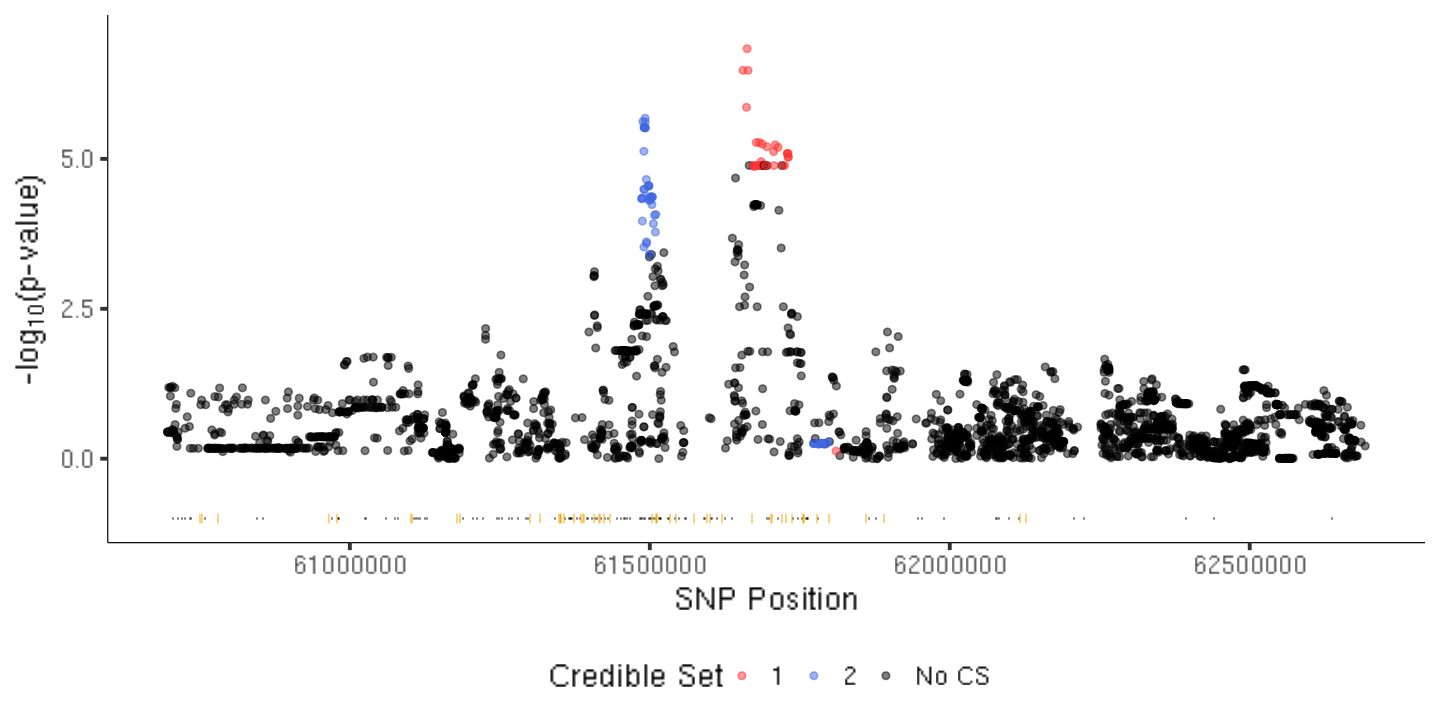

In [461]:
options(repr.plot.width=12, repr.plot.height=6)

cis.eqtl.all %>%
    dplyr::filter(gene == "ENSG00000100644") %>%
    merge(., susie.snps, by.x="snps", by.y="SNP", all.x=T) %>%
    dplyr::mutate(Credible_Set=replace(Credible_Set, is.na(Credible_Set), "No CS")) %>%
    dplyr::mutate(Credible_Set=factor(Credible_Set)) %>%
    ggplot() +
    geom_point(aes(x=SNPpos, y=-log10(pvalue), color=Credible_Set), alpha=0.5) +
    geom_segment(data=all.peaks.in.locus, aes(x=Start, xend=End, y=-1, yend=-1), size=0.5, color="black") +
    geom_segment(data=da.peaks.in.locus, aes(x=Start, xend=End, y=-1, yend=-1), size=2, color="orange") +
    scale_color_manual(name="Credible Set", values=c("1"="firebrick1", "2"="royalblue", "No CS"="black")) + 
    xlab("SNP Position") + ylab(bquote("-log"[10]*"(p-value)")) +
    ylim(-1, 7) +
    ggplot_theme

ggsave("~/eQTL_pQTL_Characterization/full.locus.png", width=12, height=6, dpi=600)

Warning message:
“Removed 2887 rows containing missing values (geom_point).”
Warning message:
“Removed 250 rows containing missing values (geom_segment).”
Warning message:
“Removed 89 rows containing missing values (geom_segment).”
Warning message:
“Removed 89 rows containing missing values (geom_vline).”
Warning message:
“Removed 89 rows containing missing values (geom_vline).”
Warning message:
“Removed 2887 rows containing missing values (geom_point).”
Warning message:
“Removed 250 rows containing missing values (geom_segment).”
Warning message:
“Removed 89 rows containing missing values (geom_segment).”
Warning message:
“Removed 89 rows containing missing values (geom_vline).”
Warning message:
“Removed 89 rows containing missing values (geom_vline).”


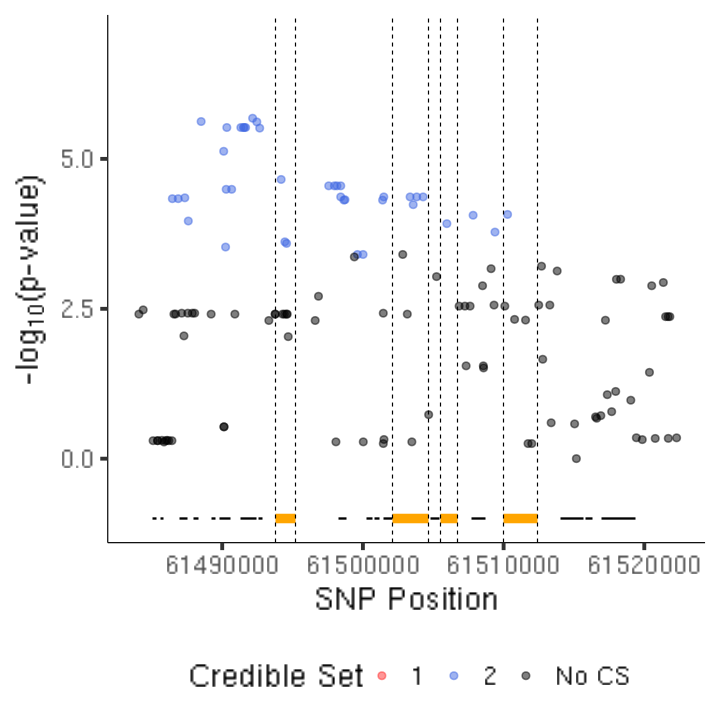

In [462]:
options(repr.plot.width=6, repr.plot.height=6)

cis.eqtl.all %>%
    dplyr::filter(gene == "ENSG00000100644") %>%
    merge(., susie.snps, by.x="snps", by.y="SNP", all.x=T) %>%
    dplyr::mutate(Credible_Set=replace(Credible_Set, is.na(Credible_Set), "No CS")) %>%
    dplyr::mutate(Credible_Set=factor(Credible_Set)) %>%
    ggplot() +
    geom_point(aes(x=SNPpos, y=-log10(pvalue), color=Credible_Set), alpha=0.5) +
    geom_segment(data=all.peaks.in.locus, aes(x=Start, xend=End, y=-1, yend=-1), size=0.5, color="black") +
    geom_segment(data=da.peaks.in.locus, aes(x=Start, xend=End, y=-1, yend=-1), size=2, color="orange") +
    geom_vline(data=da.peaks.in.locus, aes(xintercept=Start), size=0.25, lty=2) +
    geom_vline(data=da.peaks.in.locus, aes(xintercept=End), size=0.25, lty=2) +
    scale_color_manual(name="Credible Set", values=c("1"="firebrick1", "2"="royalblue", "No CS"="black")) + 
    xlab("SNP Position") + ylab(bquote("-log"[10]*"(p-value)")) +
    xlim(61493794 - 10000, 61512388 + 10000) + ylim(-1, 7) +
    ggplot_theme

ggsave("~/eQTL_pQTL_Characterization/locus.da.peaks.png", width=6, height=6, dpi=600)

Warning message:
“Removed 2886 rows containing missing values (geom_point).”
Warning message:
“Removed 242 rows containing missing values (geom_segment).”
Warning message:
“Removed 86 rows containing missing values (geom_segment).”
Warning message:
“Removed 86 rows containing missing values (geom_vline).”
Warning message:
“Removed 86 rows containing missing values (geom_vline).”
Warning message:
“Removed 2886 rows containing missing values (geom_point).”
Warning message:
“Removed 242 rows containing missing values (geom_segment).”
Warning message:
“Removed 86 rows containing missing values (geom_segment).”
Warning message:
“Removed 86 rows containing missing values (geom_vline).”
Warning message:
“Removed 86 rows containing missing values (geom_vline).”


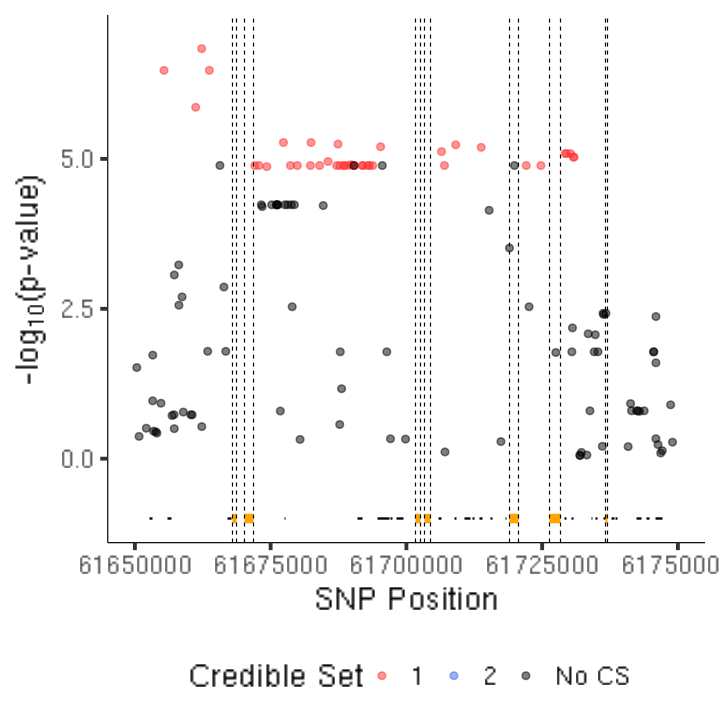

In [463]:
options(repr.plot.width=6, repr.plot.height=6)

cis.eqtl.all %>%
    dplyr::filter(gene == "ENSG00000100644") %>%
    merge(., susie.snps, by.x="snps", by.y="SNP", all.x=T) %>%
    dplyr::mutate(Credible_Set=replace(Credible_Set, is.na(Credible_Set), "No CS")) %>%
    dplyr::mutate(Credible_Set=factor(Credible_Set)) %>%
    ggplot() +
    geom_point(aes(x=SNPpos, y=-log10(pvalue), color=Credible_Set), alpha=0.5) +
    geom_segment(data=all.peaks.in.locus, aes(x=Start, xend=End, y=-1, yend=-1), size=0.5, color="black") +
    geom_segment(data=da.peaks.in.locus, aes(x=Start, xend=End, y=-1, yend=-1), size=2, color="orange") +
    geom_vline(data=da.peaks.in.locus, aes(xintercept=Start), size=0.25, lty=2) +
    geom_vline(data=da.peaks.in.locus, aes(xintercept=End), size=0.25, lty=2) +
    scale_color_manual(name="Credible Set", values=c("1"="firebrick1", "2"="royalblue", "No CS"="black")) + 
    xlab("SNP Position") + ylab(bquote("-log"[10]*"(p-value)")) +
    xlim(61650000, 61750000) + ylim(-1, 7) +
    ggplot_theme

ggsave("~/eQTL_pQTL_Characterization/locus.cs.1.png", width=6, height=6, dpi=600)